In [74]:

# from google.colab import drive
# drive.mount("/content/drive")

# %cd 'drive/My Drive/bulk_export/'
import pandas as pd
import numpy as np


### Import Data

In [75]:
#orgs=pd.read_csv("organizations.csv")
#orgs= orgs[orgs['roles'].str.contains('investor')==False].reset_index(drop=True)
import pickle
import pandas as pd
#pickle.dump( {'data':orgs,'dummies':dummycolumns}, open( "filtered_orgs.p", "wb" ) )
pickle_res = pickle.load( open( "filtered_orgs.p", "rb" ) )
orgs,dummycolumns = pickle_res['data'],pickle_res['dummies']
#randomly sample
orgs = pd.read_csv("filtered_orgs.csv")[0:10000]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [76]:
orgs=orgs[orgs['category_groups_list'].isna()==False]

In [77]:
orgs=orgs.reset_index(drop=True)

In [78]:
founders=pd.read_csv("people.csv")
founders_descriptions=pd.read_csv("people_descriptions.csv")
degrees=pd.read_csv("degrees.csv")
events=pd.read_csv("event_appearances.csv")

In [79]:
ivyleague = ['Harvard','UCLA','Stanford','MIT','Yale','Princeton','Columbia','Brown','Dartmouth','Pennsylvania','Cornell']
ivyleagers=degrees[degrees['institution_name'].str.contains("|".join(ivyleague))]
ivyleagers=founders[founders['uuid'].isin(ivyleagers['person_uuid'])]
ivyleagers=orgs[orgs['uuid'].isin(ivyleagers['featured_job_organization_uuid'])]
orgs['ivy_league']= 0
orgs['ivy_league']= [1 if i in ivyleagers.index else 0 for i in orgs.index]

In [82]:
#orgs.head()
events["created_at"]=  pd.to_datetime(events["created_at"], format='%Y-%m-%d')
events["created_at_year"] = pd.DatetimeIndex(events["created_at"]).year
events["created_at_month"] = pd.DatetimeIndex(events["created_at"]).month
events["created_at_day"] = pd.DatetimeIndex(events["created_at"]).day
org_attended=orgs[orgs['uuid'].isin(events['participant_uuid'])]
org_attended=pd.merge(org_attended,events[['participant_uuid','created_at_year']],left_on="uuid",right_on="participant_uuid")
org_attended_year=org_attended[(org_attended['created_at_year']-org_attended['founded_on_year']>0)&(org_attended['created_at_year']-org_attended['founded_on_year']< 2)]

In [83]:
participated=orgs[orgs['uuid'].isin(org_attended_year['participant_uuid'])]
orgs['particapated_event_first_year']= 0 
orgs['particapated_event_first_year']= [1 if i in participated.index else 0 for i in orgs.index]

In [84]:

#orgs['attended_first_year'] = [1 if x in org_attended_year['participant_uuid'] else 0 for x in orgs['uuid']]


### Filtering and deleting columns

In [85]:
# Richard
#orgs= orgs[orgs['roles'].str.contains('investor')==False]
#orgs['founded_on']=[ 0 if str(date) == 'nan' else date for date in orgs['founded_on']]
#orgs['founded_on']= [0 if int(str(date).split("-")[0]) < 1900 else date for date in orgs['founded_on']]
#orgs= orgs[(orgs['founded_on'] != "1534-01-01") & (orgs['founded_on']!='1472-01-01')]

### Convert Founded date to days

In [86]:
# Ang (founded_on)
# 2019-09-20 -> 365 days
# 2019-09-29 -> 2019,09,29
#import datetime


# orgs["founded_on"]=  pd.to_datetime(orgs["founded_on"], format='%Y-%m-%d')
# orgs["founded_on_year"] = pd.DatetimeIndex(orgs["founded_on"]).year
# orgs["founded_on_month"] = pd.DatetimeIndex(orgs["founded_on"]).month
# orgs["founded_on_day"] = pd.DatetimeIndex(orgs["founded_on"]).day


In [87]:
#orgs.shape

In [88]:
#orgs['status'].hist()

### One hot Encoding for Categorical

In [89]:
from pandas_profiling import ProfileReport

In [90]:
 # convert categorical columns to one hot encodings
 # Yanda 
def convertcategorical_onehot(orgs,column="category_list"):
  orgs_test = orgs
  orgs_test = orgs_test[orgs_test[column].notna()]
  orgs_test= orgs_test.reset_index()
  full_string = ""
  for index, row in orgs_test.iterrows():
    full_string += row[column] +","
  full_string = full_string[:-1]
  cl = full_string.split(",")
  cl = list(set(cl))
  indexes = list(range(0, len(orgs_test)))
  df = pd.DataFrame(0,columns=cl,index =indexes) 
  for index,row in orgs_test.iterrows():
    category_list = row[column].split(",")
    for x in category_list:
      df.at[index, x] = 1
  orgs_test = pd.concat([orgs_test, df], axis=1)
  dummycolumns= df.columns
  return(orgs_test,dummycolumns)

#orgs,dummycolumns=convertcategorical_onehot(orgs.copy(),'category_groups_list')

### Exploration

<AxesSubplot:>

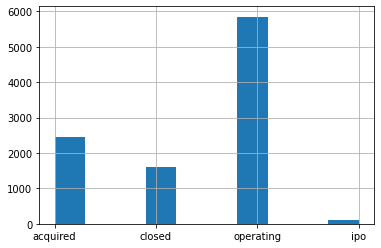

In [91]:
# Everyone

orgs['status'].hist()

In [92]:
# Possible columns
# remove rank, closed_on, num_funding_rounds
orgs_clean = orgs[['type','rank','created_at','updated_at', 'roles',
       'country_code', 'state_code', 'region', 'city', 
       'status', 'short_description', 'category_list', 
       'category_groups_list', 'num_funding_rounds', 'total_funding_usd',
       'total_funding', 'founded_on', 
       'last_funding_on', 'closed_on', 'employee_count',
        'primary_role', 'num_exits']]

# orgs_clean
## drop id-like column
## name, leagal_name, urls, domain, address, postal_code, email, phone, alias123

## other possible drops
## drop rows with closed_on == exact dates, num_exits, rank

## colinearity 
## contry_code, state_code, region, city, total_funding_currency_code (dropped)
## total_funding_usd, total_funding


In [93]:
# count of null values for each column
orgs_clean.isna().sum()

type                        0
rank                        0
created_at                  0
updated_at                  0
roles                       0
country_code             1121
state_code               3697
region                   1121
city                     1121
status                      0
short_description           0
category_list               0
category_groups_list        0
num_funding_rounds       6311
total_funding_usd        6879
total_funding            6879
founded_on                  0
last_funding_on          6311
closed_on                9214
employee_count              0
primary_role                0
num_exits               10000
dtype: int64

### Feature engineering (convert numbers to categories)

In [94]:
# Ariel

In [95]:
fundings = orgs[[ 'num_funding_rounds', 'total_funding_usd',
       'total_funding',]]
fundings

,num_funding_rounds,total_funding_usd,total_funding
0,3.0,39750000.0,39750000.0
1,6.0,49000000.0,49000000.0
2,1.0,800000.0,800000.0
3,3.0,15000000.0,15000000.0
4,NaN,NaN,NaN
...,...,...,...
9995,NaN,NaN,NaN
9996,2.0,70000000.0,70000000.0
9997,NaN,NaN,NaN
9998,NaN,NaN,NaN


In [96]:
fundings = fundings.dropna() # drop NA values

# finding difference between 'total funding usd' and 'total funding'
fundings['subtract']= fundings['total_funding_usd'] - fundings['total_funding']
fundings['subtract'].value_counts()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.0          2924
231212.0        2
1321764.0       1
2838552.0       1
2218367.0       1
             ... 
108218.0        1
250574.0        1
197814.0        1
8168.0          1
6258254.0       1
Name: subtract, Length: 197, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

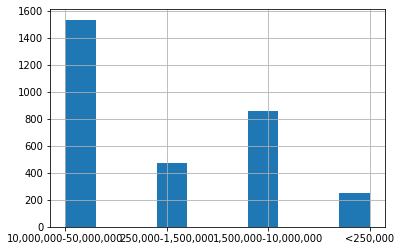

In [97]:
# create a list of our conditions
#l = {'pre-seed': 100000,'seed': 1000000, 'series A':100000-1000000, }
conditions = [
    (fundings['total_funding_usd'] <= 250000),
    (fundings['total_funding_usd'] > 250000) & (fundings['total_funding_usd'] <= 1500000),
    (fundings['total_funding_usd'] > 1500000) & (fundings['total_funding_usd'] <= 10000000),
    (fundings['total_funding_usd'] > 10000000)
    ]

# create a list of the values we want to assign for each condition
values = ['<250,000', '250,000-1,500,000', '1,500,000-10,000,000', '10,000,000-50,000,000']

# create a new column and use np.select to assign values to it using our lists as arguments
fundings['funding_group_usd'] = np.select(conditions, values)

# see all the values for 'funding_group_usd'
fundings['funding_group_usd'].value_counts()
fundings['funding_group_usd'].hist()

In [98]:
# correlation matrix of fundings
# seems like 'total_funding_usd' has low correlation with 'total_funding'

fundings.corr()

,num_funding_rounds,total_funding_usd,total_funding,subtract
num_funding_rounds,1.000000,0.270537,0.267295,0.014573
total_funding_usd,0.270537,1.000000,0.993485,0.005882
total_funding,0.267295,0.993485,1.000000,-0.108117
subtract,0.014573,0.005882,-0.108117,1.000000


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


<AxesSubplot:>

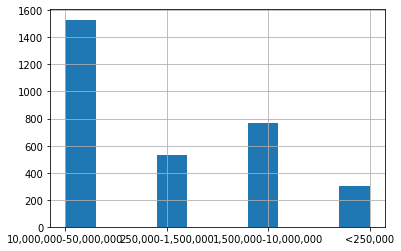

In [99]:
# create a list of our conditions for 'total_funding'
conditions = [
    (fundings['total_funding'] <= 300000),
    (fundings['total_funding'] > 300000) & (fundings['total_funding'] <= 2000000),
    (fundings['total_funding'] > 2000000) & (fundings['total_funding'] <= 10000000),
    (fundings['total_funding'] > 10000000)
    ]

# create a list of the values we want to assign for each condition
values = ['<250,000', '250,000-1,500,000', '1,500,000-10,000,000', '10,000,000-50,000,000']

# create a new column and use np.select to assign values to it using our lists as arguments
fundings['funding_group'] = np.select(conditions, values)

# See all the values of 'funding_group'
fundings['funding_group'].value_counts()
fundings['funding_group'].hist()

### Stratified Split

In [100]:
#orgs.drop(['name','type','roles','state_code','index','uuid','address','permalink','cb_url','created_at','rank','updated_at','legal_name','postal_code','domain','homepage_url','num_funding_rounds','total_funding_usd','total_funding_currency_code','facebook_url','linkedin_url','twitter_url','alias1','alias2','alias3','primary_role','num_exits','logo_url','short_description','total_funding','founded_on','category_list','category_groups_list','last_funding_on','closed_on','employee_count','email','phone'],inplace=True,axis=1)
orgs.drop(['name','type','roles','state_code','index','uuid','address','permalink','cb_url','created_at','rank','updated_at','legal_name','postal_code','domain','homepage_url','num_funding_rounds','total_funding_currency_code','facebook_url','linkedin_url','twitter_url','alias1','alias2','alias3','primary_role','num_exits','logo_url','short_description','total_funding','founded_on','category_list','category_groups_list','last_funding_on','closed_on','employee_count','email','phone'],inplace=True,axis=1)

profiler=orgs.profile_report()

In [101]:
profiler.to_file(output_file="reportcrunchbase.html")

Summarize dataset:   0%|          | 0/71 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [102]:
orgs=orgs[orgs['status'].isna()==False]
orgs=orgs[orgs['status'].isin(['acquired','closed','operating','ipo'])]
from collections import Counter
Counter(orgs['status'])
orgs['status']= [0 if x =='closed' else 1 for x in orgs['status']]

In [103]:
orgs.drop(['Unnamed: 0'],axis=1,inplace=True)
orgs.reset_index(drop=True,inplace=True)

In [104]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(orgs, orgs['status']):
     strat_train_set = orgs.loc[train_index]
     strat_test_set = orgs.loc[test_index]

data_raised=strat_train_set['total_funding_usd']
data = strat_train_set.copy().drop(['status','total_funding_usd'],axis=1)
data_labels = strat_train_set["status"].copy()

data_cat=data[['country_code', 'region', 'city' ]]


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
print("Starting phase 1 ")
data_num = data.select_dtypes(include=[np.number])
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

data_num_tr = num_pipeline.fit_transform(data_num)

print("Starting starting phase 2 ")

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
data[data_cat.columns]=data[data_cat.columns].astype(str)
num_attribs = list(data_num)
cat_attribs = list(data_cat.columns)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
    ])

data_prepared = full_pipeline.fit_transform(data.copy())


Starting phase 1 
Starting starting phase 2 


In [105]:

#Get the feature names
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_extraction.text import _VectorizerMixin
def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

cols = get_ct_feature_names(full_pipeline)
data_processed_columns=pd.DataFrame(data_prepared.toarray(), columns=get_ct_feature_names(full_pipeline))

test_raised=strat_test_set['total_funding_usd']
X_test = strat_test_set.drop(['status','total_funding_usd'],axis=1)
X_test[cat_attribs]=X_test[cat_attribs].astype(str)
y_test = strat_test_set["status"].copy()
X_test=full_pipeline.transform(X_test)



In [106]:
print("rebalancing")
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN 
#strategy = {0:5000,1:5000}
sme = SMOTEENN(random_state=42)#strategy = strategy)
data_prepared_balanced, data_labels_balanced = sme.fit_resample(data_prepared.copy(), data_labels)
#data_prepared_balanced, data_labels_balanced = data_prepared.copy(),data_labels#sme.fit_resample(data_prepared.copy(), data_labels)


rebalancing


In [69]:
data_processed_balanced_columns=pd.DataFrame(data_prepared_balanced.toarray(), columns=get_ct_feature_names(full_pipeline))

Counter(data_labels)

Counter({0: 1276, 1: 6724})

In [ ]:
Counter(data_labels_balanced)

### Feature Selection

In [70]:
# Random Forest
# Load libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Run Random Forest
rf = RandomForestClassifier(random_state=5, n_estimators=100)
model = rf.fit(data_prepared_balanced,data_labels_balanced)
# Using the model to predict the results based on the test dataset
y_test_pred = model.predict(X_test)
# Calculate the mean squared error of the prediction
accuracy_ratio = accuracy_score(y_test, y_test_pred)
print(accuracy_ratio)
importance = model.feature_importances_
importances_named=pd.DataFrame(rf.feature_importances_)
importances_named.index=data_processed_columns.columns

# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))


from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_],self.feature_indices_
    
k=100
#top_k_feature_indices = indices_of_top_k(forest_reg.feature_importances_, 10)
#Feature selection using top feature selector
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(rf.feature_importances_, k))
])

data_prepared_top,indices = preparation_and_feature_selection_pipeline.fit_transform(data.copy())


0.709


In [ ]:
y_test

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
#roc_auc_score(y, rf.decision_function(X_test))
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

perf_measure(y_test.reset_index(drop=True),rf.predict(X_test))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
sn.heatmap(confusion_matrix(y_test.reset_index(drop=True),rf.predict(X_test)), annot=True)


In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
importances_named.sort_values(by=0,ascending=False)[0:50].plot.bar()

In [ ]:
Counter(y_test_pred)

### False Positive + False NEgatives + AUROC

In [ ]:
Counter(y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(data_prepared_balanced, data_labels_balanced)


In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

In [ ]:
model = RandomForestClassifier(random_state=42,bootstrap=False,max_features= 4,n_estimators= 10)
model.fit(data_prepared_balanced, data_labels_balanced)
y_test_pred = model.predict(X_test)
# Calculate the mean squared error of the prediction
accuracy_ratio = accuracy_score(y_test, y_test_pred)
print(accuracy_ratio)
importance = model.feature_importances_
importances_named=pd.DataFrame(rf.feature_importances_)
importances_named.index=data_processed_columns.columns

In [ ]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
importances_named.sort_values(by=0,ascending=False)[0:50].plot.bar()

### XGBoost 

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 1.5],
        'max_depth': [3, 4],
        'n_estimators': [3, 10, 30],
        }

from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42,silent=True)
grid_search = GridSearchCV(xgb, params, cv=10,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(data_prepared_balanced, data_labels_balanced)

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

### CasualML

In [109]:
treatment = [0 if x < 0 else 1 for x in data_processed_balanced_columns['ivy_league']] 

In [108]:
top_balanced=data_processed_balanced_columns[data_processed_balanced_columns.columns[indices]]

In [139]:
uplift_model

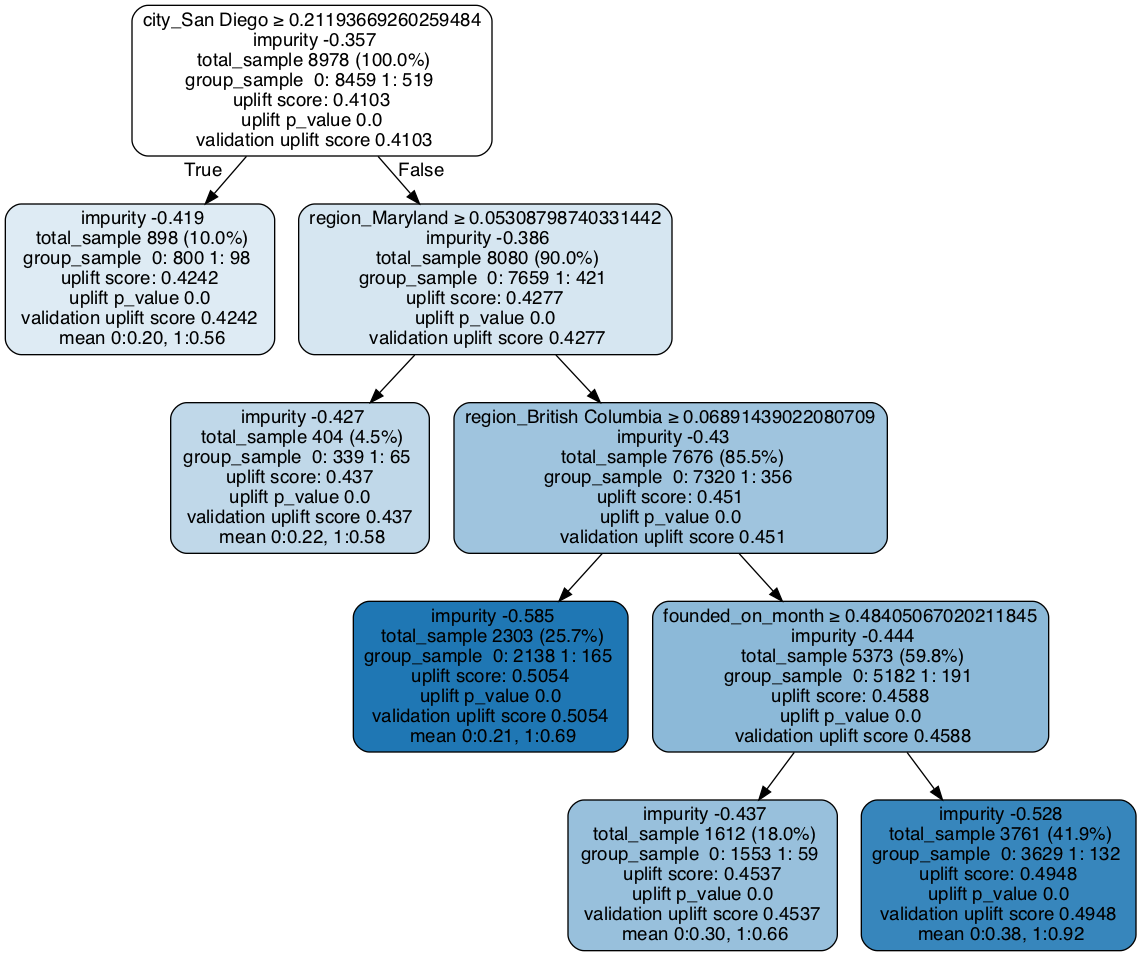

In [132]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
y, X, treatment = data_labels_balanced.reset_index(drop=True),np.array(top_balanced.drop(['ivy_league'],axis=1)),np.array(treatment)

uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='0')

uplift_model.fit(X,
                 treatment=treatment.astype(str),
                 y=y)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, list(top_balanced.columns))
Image(graph.create_png())

In [141]:
result = uplift_tree_string(uplift_model.fitted_uplift_tree, list(top_balanced.columns))
result

city_San Diego >= 0.21193669260259484?
yes -> {'0': 0.2, '1': 0.561224}
no  -> region_Maryland >= 0.05308798740331442?
		yes -> {'0': 0.218289, '1': 0.584615}
		no  -> region_British Columbia >= 0.06891439022080709?
				yes -> {'0': 0.207671, '1': 0.690909}
				no  -> founded_on_month >= 0.48405067020211845?
						yes -> {'0': 0.298777, '1': 0.661017}
						no  -> {'0': 0.377239, '1': 0.916667}


In [153]:
from causalml.inference.meta import BaseXClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
#Propensity Model
prop_model = LGBMClassifier(colsample_bytree=0.8, subsample = 0.8, n_estimators=300)
print(cross_val_score(prop_model, X, treatment, cv=5, scoring='roc_auc').mean())
#model achieves AUC of 0.57, which makes it useful in evaluating the test outcome

#Fitting the model
prop_model.fit(X, treatment)

#Getting propensity scores
prop_scores = prop_model.predict_proba(X)


learner_x = BaseXClassifier(LGBMClassifier(colsample_bytree=0.8, num_leaves=50, n_estimators=200),
                            control_effect_learner=LinearRegression(),
                            treatment_effect_learner=LinearRegression(), control_name=0)

#Getting the average treatment effect with upper and lower bounds
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p = prop_scores[:, 1])
print(ate_x, ate_x_lb, ate_x_ub)

0.8140579790852055
[1.2578755e+10] [7.46614963e+09] [1.76913603e+10]


In [172]:
len(orgs[(orgs['ivy_league']==1)&(orgs['status']==1)])/len(orgs[orgs['ivy_league']==1])

0.9436038514442916

In [176]:
len(orgs[(orgs['ivy_league']==1)&(orgs['status']==0)])/len(orgs[orgs['ivy_league']==1])

0.05639614855570839

In [174]:
len(orgs[(orgs['ivy_league']==0)&(orgs['status']==1)])/len(orgs[orgs['ivy_league']==0])

0.832416693626658

In [169]:
orgs[['ivy_league','status']].profile_report()

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [119]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor
from causalml.dataset import synthetic_data

from lightgbm import LGBMRegressor
y, X, treatment = data_labels_balanced.reset_index(drop=True),np.array(top_balanced.drop(['ivy_league'],axis=1)),np.array(treatment)

lr = LRSRegressor()
telr, lblr, ublr = lr.estimate_ate(X,treatment, y)
lr_tau = lr.fit_predict(X, treatment, y)

print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(telr[0], lblr[0], ublr[0]))
xg = XGBTRegressor(random_state=42)
texg, lbxg, ubxg = xg.estimate_ate(X, treatment, y)
xg_tau = xg.fit_predict(X, treatment, y)


print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(texg[0], lbxg[0], ubxg[0]))


# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 8000 but corresponding boolean dimension is 8978

In [ ]:
from causalml.inference.meta import BaseSRegressor
base_algo = LGBMRegressor()
slearner = BaseSRegressor(base_algo, control_name=0)
slearner.estimate_ate(X, treatment, data_labels_balanced.reset_index(drop=True))
slearner_tau = slearner.fit_predict(X, treatment, data_labels_balanced.reset_index(drop=True))

In [ ]:
import matplotlib.pyplot as plt

lr.plot_importance(X=X, 
                        tau=lr_tau,
                        normalize=True, 
                        method='auto', 
                        features=top_balanced.drop(['ivy_league'],axis=1).columns)
lr.plot_importance(X=X, 
                         tau=lr_tau, 
                         method='permutation', 
                         features=top_balanced.drop(['ivy_league'],axis=1).columns, 
                         random_state=42)
xg.plot_importance(X=X, 
                        tau=xg_tau,
                        normalize=True, 
                        method='auto', 
                        features=top_balanced.drop(['ivy_league'],axis=1).columns)

xg.plot_importance(X=X, 
                        tau=xg_tau,
                        normalize=True, 
                        method='permutation', 
                        features=top_balanced.drop(['ivy_league'],axis=1).columns)

slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=top_balanced.drop(['ivy_league'],axis=1).columns)

slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='permutation', 
                         features=top_balanced.drop(['ivy_league'],axis=1).columns)

### Semi-supervised Clustering ML


In [181]:
orgs2 = pd.read_csv("organizations.csv")

In [182]:
orgsdesc = pd.read_csv("organization_descriptions.csv")

In [183]:
orgs2=pd.merge(orgs2,orgsdesc[['uuid','description']],left_on="uuid",right_on="uuid")

In [259]:
holt=pd.read_excel("labelled_manually.xlsx")

In [260]:
holtcomps = holt[holt['Startup/Person Name'].isin(orgs2['name'])]

In [261]:
orgsnew=pd.read_csv("filtered_orgs.csv")

In [262]:
orgsholt=orgsnew[orgsnew['name'].isin(holtcomps['Startup/Person Name'])]

In [263]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
clustering = AgglomerativeClustering().fit(orgsholt[dummycolumns])

In [264]:
orgsholt=pd.merge(orgsholt,holtcomps[['Startup/Person Name','Question 1: What market are you addressing?']],left_on="name",right_on="Startup/Person Name")

In [265]:
orgsholt=orgsholt[orgsholt['Question 1: What market are you addressing?'].isna()==False]
orgsholt.reset_index(drop=True,inplace=True)

In [266]:
orgsholt['Question 1: What market are you addressing?']

0               Blockchain / Cryptocurrency
1               Blockchain / Cryptocurrency
2                   Payments / Transactions
3                   Payments / Transactions
4                             CyberSecurity
                       ...                 
114                                 Lending
115    Investment Banking / Capital Markets
116                                 Lending
117             Institutional / B2B Fintech
118                 Payments / Transactions
Name: Question 1: What market are you addressing?, Length: 119, dtype: object

In [257]:

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

k =50
kmeans = KMeans(n_clusters=k)
sample = orgsholt[dummycolumns][0:50]
sample_labels = orgsholt['Question 1: What market are you addressing?'][0:50]
X_digits_dist = kmeans.fit_transform(sample)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = sample.values[representative_digit_idx]

log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, sample_labels)
log_reg.score(orgsholt[dummycolumns][50:len(orgsholt)],orgsholt['Question 1: What market are you addressing?'][50:len(orgsholt)])

0.13043478260869565

In [ ]:
# accuracy too low